In [1]:
!pip install -q clu

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.2.1 which is incompatible.
tensorflow 2.15.0 requires ml-dtypes~=0.2.0, but you have ml-dtypes 0.4.0 which is incompatible.


In [2]:
from functools import partial
import jax
import jax.numpy as jnp
from flax import linen as nn
from jax.nn.initializers import lecun_normal, normal
from jax.numpy.linalg import eigh, inv, matrix_power
from jax.scipy.signal import convolve

import torch

from dataclasses import dataclass

from typing import Union

import matplotlib.pyplot as plt
import seaborn

from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers
from tqdm import tqdm

In [3]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-05-13 07:37:34--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: 'input.txt'

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2024-05-13 07:37:35 (18.5 MB/s) - 'input.txt' saved [1115394/1115394]



In [4]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [5]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [6]:
# create a mapping from characters to integers
stoi = { ch: i for i,ch in enumerate(chars) }
itos = { i: ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [7]:
data = jnp.array(encode(text), dtype=jnp.int32)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

(1115394,) int32
[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43
 39 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49
  6  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10
  0 37 53 59  1 39 56 43  1 39 50 50  1 56 43 57 53 50 60 43 42  1 56 39
 58 46 43 56  1 58 53  1 42 47 43  1 58 46 39 52  1 58 53  1 44 39 51 47
 57 46 12  0  0 13 50 50 10  0 30 43 57 53 50 60 43 42  8  1 56 43 57 53
 50 60 43 42  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 18 47
 56 57 58  6  1 63 53 59  1 49 52 53 61  1 15 39 47 59 57  1 25 39 56 41
 47 59 57  1 47 57  1 41 46 47 43 44  1 43 52 43 51 63  1 58 53  1 58 46
 43  1 54 43 53 54 50 43  8  0  0 13 50 50 10  0 35 43  1 49 52 53 61  5
 58  6  1 61 43  1 49 52 53 61  5 58  8  0  0 18 47 56 57 58  1 15 47 58
 47 64 43 52 10  0 24 43 58  1 59 57  1 49 47 50 50  1 46 47 51  6  1 39
 52 42  1 61 43  5 50 50  1 46 39 

In [8]:
train_test_split = 0.9
n = int(train_test_split*len(data))
train_data = data[:n]
test_data = data[n:]

In [9]:
block_size = 8
train_data[:block_size+1]

Array([18, 47, 56, 57, 58,  1, 15, 47, 58], dtype=int32)

In [10]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is [18] the target: 47
when input is [18 47] the target: 56
when input is [18 47 56] the target: 57
when input is [18 47 56 57] the target: 58
when input is [18 47 56 57 58] the target: 1
when input is [18 47 56 57 58  1] the target: 15
when input is [18 47 56 57 58  1 15] the target: 47
when input is [18 47 56 57 58  1 15 47] the target: 58


In [11]:
batch_size = 512 # how many independent sequences will we process in parallel?
block_size = 64 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 1e-3
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 128
expans = 2
n_head = 4
channel_size = n_embd // n_head
n_layers = 4
dropout = 0.2
conv_k_size = 3
n_latent_dim = 16

rng_key = jax.random.PRNGKey(1564)

dynamic_slice_vmap = jax.vmap(jax.lax.dynamic_slice, in_axes=(None, 0, None))

@jax.jit
def get_batch(random_key, data):
    """Prepares a random batch of training data.

    Args:
      random_key: A random seed for sampling a batch.
      data: The complete training dataset.

    Returns:
      x: Input sequences.
      y: Target sequences (shifted inputs).
    """
    ix = jax.random.randint(
      random_key, shape=(batch_size, 1), minval=0, maxval=len(data) - block_size
    )
    x = dynamic_slice_vmap(data, ix, (block_size,))
    y = dynamic_slice_vmap(data, ix + 1, (block_size,))
    return x, y

xb, yb = get_batch(rng_key, train_data)
train_shape = xb.shape
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

# print('----')

# for b in range(batch_size): # batch dimension
#     for t in range(block_size): # time dimension
#         context = xb[b, :t+1]
#         target = yb[b,t]
#         print(f"when input is {context} the target: {target}")

inputs:
(512, 64)
[[33 23 17 ... 53 52 45]
 [ 0 37 53 ... 52 52 53]
 [53 52 42 ... 59 47 58]
 ...
 [52 42  1 ... 58 46  1]
 [37 53 59 ...  1 61 47]
 [17 26 34 ... 39 52  1]]
targets:
(512, 64)
[[23 17  1 ... 52 45 59]
 [37 53 59 ... 52 53 58]
 [52 42 43 ... 47 58  7]
 ...
 [42  1 63 ... 46  1 54]
 [53 59  1 ... 61 47 50]
 [26 34 27 ... 52  1 40]]


In [12]:
class RMSNorm(nn.Module):
    d_model: int
    eps: float = 1e-5

    @nn.compact
    def __call__(self, x):
        weight = self.param('weight', nn.initializers.ones, (self.d_model,)) # TODO, maybe use setup will be more clear
        normed = x * jax.lax.rsqrt(np.mean(np.square(x), axis=-1, keepdims=True) + self.eps)
        output = normed * weight
        return output

In [13]:
xb.shape

(512, 64)

In [14]:
class Expan_proj(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=n_embd)(x)
        return x
    
in_proj = nn.Dense(features=n_embd)
params = in_proj.init(rng_key, xb)
in_proj.apply(params, xb).shape

(512, 128)

In [15]:
jax.tree_util.tree_map(lambda x: x.shape, params)

{'params': {'bias': (128,), 'kernel': (64, 128)}}

# Mamba Block
Dense --> Conv1D --> Silu --> SSM --> Silu --> 

In [16]:
class MambaBlock(nn.Module):
    
    def setup(self):          
        self.in_proj1 = nn.Dense(features=n_embd * expans)
        self.in_proj2 = nn.Dense(features=n_embd * expans)
        
        # Adjusted for Flax. Flax does not have nn.Conv1d, so you might need to reshape or use a different approach
        self.conv1d = nn.Conv(features=n_embd * expans,
                              kernel_size=conv_k_size,
                              padding=1,
                              )

        self.A = -1*self.param('A', nn.initializers.ones, (1, n_latent_dim, n_embd * expans, 1))
        self.B = self.param('B', nn.initializers.ones, (1, n_latent_dim, 1, block_size))
        self.C = self.param('C', jax.random.normal, (1, n_latent_dim, 1, block_size))
#         self.D = self.param('D', jax.random.normal, (1, self.args.d_state, self.args.d_model, 1))
        self.delta = self.param('delta', jax.random.normal, (1, 1, n_embd * expans, block_size))
        
        self.out_proj = nn.Dense(n_embd)
        
        self.rms_norm = nn.RMSNorm()
        
    def __call__(self, x):
        
        embeds = x
        x = self.in_proj1(embeds)
        x = self.conv1d(x)
        x = jax.nn.silu(x)
        x = x.reshape((x.shape[0],1,x.shape[2],x.shape[1]))
        x = self.ssm(x)[1]
        x = x.reshape((x.shape[0],x.shape[3],x.shape[2]))
        x = x*jax.nn.silu(self.in_proj2(embeds))

        x = self.out_proj(x)
        
        x = self.rms_norm(x)
        
        return x
    def discretize(self):
        da = self.delta * self.A
        a_ = jnp.exp(da)
        b_ = self.C * self.delta
        return a_, b_

    def ssm(self, x):
        y = []
        h = 0
        a_, b_ = self.discretize()
        for k in range(x.shape[-1]):
            h = a_[..., k] * h + b_[..., k] * x[..., k]
            y.append((self.C[..., k] * h).sum(1, keepdims=True))
        return h, jnp.stack(y, -1)

In [17]:
# model = MambaBlock()
# params = model.init(jax.random.key(0), xb)
# print(model.tabulate(jax.random.key(0), xb,
#                    compute_flops=True, compute_vjp_flops=True))
# xs = model.apply(params, xb)
# xb.shape, xs.shape

In [18]:
class Mamba(nn.Module):
    
    def setup(self):
        self.embeddings = nn.Embed(vocab_size, n_embd)
        
        self.mamba_layers = [MambaBlock() for _ in range(n_layers)]
        
    def __call__(self, x):
        x = self.embeddings(x)
        
        for layer in self.mamba_layers:
            x = layer(x)
            
        out = self.embeddings.attend(x)
        return out
    
    @jax.jit
    def generate(self, idx, max_new_tokens, params):
    # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits = self.apply(params, idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            ##probs = tf.keras.activations.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = jax.random.categorical(jax.random.PRNGKey(52), logits) # (B, 1)
            # append sampled index to the running sequence
            idx = jax.numpy.expand_dims(jnp.concatenate([idx[0], idx_next], axis=0), 0) # (B, T+1)
    #         print(idx_next)
    #         print(idx)

        return idx    

In [19]:
class NanoLM(nn.Module):
    """NanoLM model."""
    vocab_size: int = 65
    num_layers: int = 6
    num_heads: int = 8
    head_size: int = 32
    dropout_rate: float = 0.2
    embed_size: int = 256
    block_size: int = 64

    @nn.compact
    def __call__(self, x, training: bool):
        seq_len = x.shape[1]

        x = nn.Embed(self.vocab_size, self.embed_size)(x) + nn.Embed(
            self.block_size, self.embed_size
        )(jnp.arange(seq_len))
        for _ in range(self.num_layers):
            x_norm = nn.LayerNorm()(x)
            x = x + nn.MultiHeadDotProductAttention(
              num_heads=self.num_heads,
              qkv_features=self.head_size,
              out_features=self.head_size * self.num_heads,
              dropout_rate=self.dropout_rate,
            )(
              x_norm,
              x_norm,
              mask=jnp.tril(jnp.ones((x.shape[-2], x.shape[-2]))),
              deterministic=not training,
            )

            x = x + nn.Sequential([
              nn.Dense(4 * self.embed_size),
              nn.relu,
              nn.Dropout(self.dropout_rate, deterministic=not training),
              nn.Dense(self.embed_size),
            ])(nn.LayerNorm()(x))

        x = nn.LayerNorm()(x)
        return nn.Dense(self.vocab_size)(x)

In [20]:
key = jax.random.key(42)

# fin_model = Mamba()
# fin_params = fin_model.init(jax.random.key(42), xb)

fin_model = NanoLM(
    vocab_size=vocab_size,
    num_layers=4,
    num_heads=8,
    head_size=32,
    dropout_rate=0.2,
    embed_size=256,
    block_size=64,
)

fin_params = fin_model.init(
    key,
    jnp.ones((batch_size, block_size), dtype=jnp.int32),
    training=False,
)

n_params = sum(p.size for p in jax.tree_util.tree_leaves(fin_params))
print(f"Total number of parameters: {n_params:_}")
# print(fin_model.tabulate(jax.random.key(42), xb,
#                    compute_flops=True, compute_vjp_flops=True))
xf = fin_model.apply(fin_params, xb, training=False)
xb.shape, xf.shape

Total number of parameters: 2_289_089


((512, 64), (512, 64, 65))

In [21]:
# token_gen = generate(jnp.zeros((1,1)).astype(jnp.int32), 100, fin_model, fin_params)
# print(token_gen)
# print(decode(token_gen[0].tolist()))

In [22]:
jax.random.categorical(jax.random.PRNGKey(5332), 1000.0*xf[1][-1][:])

Array(43, dtype=int32)

In [23]:
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

In [24]:
class TrainState(train_state.TrainState):
    metrics: Metrics

def create_train_state(module, rng, learning_rate, train_shape):
    """Creates an initial `TrainState`."""
    params = module.init(rng, jnp.ones(train_shape).astype(jnp.int32), training=False)['params'] # initialize parameters by passing a template image
    tx = optax.adamw(learning_rate)
    return TrainState.create(
      apply_fn=module.apply, params=params, tx=tx,
      metrics=Metrics.empty(),
    )

In [25]:
@jax.jit
def train_step(state, inputs, targets, key):
    """Train for a single step."""
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, inputs, training=True, rngs={"dropout": key})
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=targets).mean()
        return loss
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state

In [26]:
@jax.jit
def compute_metrics(*, state, inputs, targets):
    logits = state.apply_fn({'params': state.params}, inputs, training=False)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=targets).mean()
    metric_updates = state.metrics.single_from_model_output(
    logits=logits, labels=targets, loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [27]:
num_epochs = 10
learning_rate = 0.005
init_rng = jax.random.key(0)

In [28]:
state = create_train_state(fin_model, init_rng, learning_rate, train_shape)
del init_rng  # Must not be used anymore.

In [29]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

In [30]:
SEED = 442
key = jax.random.PRNGKey(SEED)
for step in tqdm(range(max_iters)): # increase number of steps for good results... 
    
      # sample a batch of data
    xb, yb = get_batch(key, train_data)
    state = train_step(state, xb, yb, key)
    state = compute_metrics(state=state, inputs=xb, targets=yb)
    
    key = (jax.random.split(key)[0])
    
    if (step+1) % 100 == 0: # one training epoch has passed
        for metric,value in state.metrics.compute().items(): # compute metrics
            metrics_history[f'train_{metric}'].append(value) # record metrics
        state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

        # Compute metrics on the test set after each training epoch
        test_state = state
        x_test, y_test = get_batch(key, test_data)
    #     for test_batch in test_ds.as_numpy_iterator():
        test_state = compute_metrics(state=test_state, inputs=x_test, targets=y_test)

        for metric,value in test_state.metrics.compute().items():
            metrics_history[f'test_{metric}'].append(value)

        print(f"train epoch: {(step+1)}, "
              f"loss: {metrics_history['train_loss'][-1]}, "
              f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
        print(f"test epoch: {(step+1) }, "
          f"loss: {metrics_history['test_loss'][-1]}, "
          f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")    

  2%|▏         | 100/5000 [00:37<51:04,  1.60it/s] 

train epoch: 100, loss: 3.2242727279663086, accuracy: 16.132017135620117
test epoch: 100, loss: 2.6951980590820312, accuracy: 24.3194580078125


  4%|▍         | 200/5000 [00:59<46:41,  1.71it/s]

train epoch: 200, loss: 2.4717977046966553, accuracy: 28.721433639526367
test epoch: 200, loss: 2.3022379875183105, accuracy: 32.6080322265625


  6%|▌         | 300/5000 [01:22<46:30,  1.68it/s]

train epoch: 300, loss: 2.153968572616577, accuracy: 36.761749267578125
test epoch: 300, loss: 2.1018285751342773, accuracy: 37.92724609375


  8%|▊         | 400/5000 [01:46<46:37,  1.64it/s]

train epoch: 400, loss: 1.925490379333496, accuracy: 42.59041976928711
test epoch: 400, loss: 1.9819847345352173, accuracy: 41.595458984375


 10%|█         | 500/5000 [02:09<45:20,  1.65it/s]

train epoch: 500, loss: 1.7655950784683228, accuracy: 46.831024169921875
test epoch: 500, loss: 1.8622592687606812, accuracy: 44.6197509765625


 12%|█▏        | 600/5000 [02:33<43:54,  1.67it/s]

train epoch: 600, loss: 1.6654959917068481, accuracy: 49.39984130859375
test epoch: 600, loss: 1.7926396131515503, accuracy: 46.3134765625


 14%|█▍        | 700/5000 [02:56<43:00,  1.67it/s]

train epoch: 700, loss: 1.6020132303237915, accuracy: 51.006465911865234
test epoch: 700, loss: 1.7807114124298096, accuracy: 46.6522216796875


 16%|█▌        | 800/5000 [03:20<42:18,  1.65it/s]

train epoch: 800, loss: 1.552164077758789, accuracy: 52.352081298828125
test epoch: 800, loss: 1.7264409065246582, accuracy: 48.626708984375


 18%|█▊        | 900/5000 [03:43<41:01,  1.67it/s]

train epoch: 900, loss: 1.5123411417007446, accuracy: 53.407012939453125
test epoch: 900, loss: 1.7125542163848877, accuracy: 48.919677734375


 20%|██        | 1000/5000 [04:06<39:55,  1.67it/s]

train epoch: 1000, loss: 1.4813237190246582, accuracy: 54.22195053100586
test epoch: 1000, loss: 1.6811531782150269, accuracy: 49.9603271484375


 22%|██▏       | 1100/5000 [04:30<39:10,  1.66it/s]

train epoch: 1100, loss: 1.4493672847747803, accuracy: 55.034210205078125
test epoch: 1100, loss: 1.6543018817901611, accuracy: 50.982666015625


 24%|██▍       | 1200/5000 [04:53<38:02,  1.66it/s]

train epoch: 1200, loss: 1.4281054735183716, accuracy: 55.611507415771484
test epoch: 1200, loss: 1.6523923873901367, accuracy: 50.970458984375


 26%|██▌       | 1300/5000 [05:17<37:10,  1.66it/s]

train epoch: 1300, loss: 1.4045679569244385, accuracy: 56.24267578125
test epoch: 1300, loss: 1.6073664426803589, accuracy: 52.1270751953125


 28%|██▊       | 1400/5000 [05:40<36:13,  1.66it/s]

train epoch: 1400, loss: 1.3888992071151733, accuracy: 56.688690185546875
test epoch: 1400, loss: 1.5825072526931763, accuracy: 52.8076171875


 30%|███       | 1500/5000 [06:04<35:07,  1.66it/s]

train epoch: 1500, loss: 1.3709163665771484, accuracy: 57.15643310546875
test epoch: 1500, loss: 1.623213768005371, accuracy: 52.16064453125


 32%|███▏      | 1600/5000 [06:27<34:06,  1.66it/s]

train epoch: 1600, loss: 1.359357237815857, accuracy: 57.434688568115234
test epoch: 1600, loss: 1.5840747356414795, accuracy: 52.91748046875


 34%|███▍      | 1700/5000 [06:51<33:04,  1.66it/s]

train epoch: 1700, loss: 1.3437222242355347, accuracy: 57.899688720703125
test epoch: 1700, loss: 1.5361801385879517, accuracy: 54.2083740234375


 36%|███▌      | 1800/5000 [07:14<32:05,  1.66it/s]

train epoch: 1800, loss: 1.332959771156311, accuracy: 58.1878662109375
test epoch: 1800, loss: 1.5858790874481201, accuracy: 53.21044921875


 38%|███▊      | 1900/5000 [07:37<31:06,  1.66it/s]

train epoch: 1900, loss: 1.325555443763733, accuracy: 58.37514877319336
test epoch: 1900, loss: 1.5556552410125732, accuracy: 53.900146484375


 40%|████      | 2000/5000 [08:01<30:05,  1.66it/s]

train epoch: 2000, loss: 1.3168755769729614, accuracy: 58.575469970703125
test epoch: 2000, loss: 1.5534403324127197, accuracy: 53.9703369140625


 42%|████▏     | 2100/5000 [08:24<29:02,  1.66it/s]

train epoch: 2100, loss: 1.3080683946609497, accuracy: 58.80767822265625
test epoch: 2100, loss: 1.5630700588226318, accuracy: 53.5186767578125


 44%|████▍     | 2200/5000 [08:48<28:05,  1.66it/s]

train epoch: 2200, loss: 1.2995277643203735, accuracy: 59.083587646484375
test epoch: 2200, loss: 1.5517362356185913, accuracy: 53.851318359375


 46%|████▌     | 2300/5000 [09:11<26:55,  1.67it/s]

train epoch: 2300, loss: 1.2944416999816895, accuracy: 59.184234619140625
test epoch: 2300, loss: 1.5424091815948486, accuracy: 54.180908203125


 48%|████▊     | 2400/5000 [09:34<26:00,  1.67it/s]

train epoch: 2400, loss: 1.2871530055999756, accuracy: 59.35457992553711
test epoch: 2400, loss: 1.5488859415054321, accuracy: 54.28466796875


 50%|█████     | 2500/5000 [09:58<25:01,  1.66it/s]

train epoch: 2500, loss: 1.2802261114120483, accuracy: 59.590728759765625
test epoch: 2500, loss: 1.5186386108398438, accuracy: 54.5013427734375


 52%|█████▏    | 2600/5000 [10:21<24:00,  1.67it/s]

train epoch: 2600, loss: 1.2736306190490723, accuracy: 59.72845458984375
test epoch: 2600, loss: 1.5494709014892578, accuracy: 54.5379638671875


 54%|█████▍    | 2700/5000 [10:45<23:04,  1.66it/s]

train epoch: 2700, loss: 1.269038200378418, accuracy: 59.865413665771484
test epoch: 2700, loss: 1.53364896774292, accuracy: 54.35791015625


 56%|█████▌    | 2800/5000 [11:08<21:59,  1.67it/s]

train epoch: 2800, loss: 1.2634764909744263, accuracy: 60.024566650390625
test epoch: 2800, loss: 1.5273730754852295, accuracy: 55.072021484375


 58%|█████▊    | 2900/5000 [11:31<21:01,  1.67it/s]

train epoch: 2900, loss: 1.2574766874313354, accuracy: 60.182647705078125
test epoch: 2900, loss: 1.5158941745758057, accuracy: 55.45654296875


 60%|██████    | 3000/5000 [11:55<20:04,  1.66it/s]

train epoch: 3000, loss: 1.2512043714523315, accuracy: 60.355377197265625
test epoch: 3000, loss: 1.5143002271652222, accuracy: 55.3009033203125


 62%|██████▏   | 3100/5000 [12:18<19:01,  1.66it/s]

train epoch: 3100, loss: 1.2491199970245361, accuracy: 60.37734603881836
test epoch: 3100, loss: 1.5300557613372803, accuracy: 55.352783203125


 64%|██████▍   | 3200/5000 [12:41<17:56,  1.67it/s]

train epoch: 3200, loss: 1.2445939779281616, accuracy: 60.517578125
test epoch: 3200, loss: 1.5141959190368652, accuracy: 55.2459716796875


 66%|██████▌   | 3300/5000 [13:05<17:00,  1.67it/s]

train epoch: 3300, loss: 1.240470051765442, accuracy: 60.62677001953125
test epoch: 3300, loss: 1.5153577327728271, accuracy: 55.2886962890625


 68%|██████▊   | 3400/5000 [13:28<16:02,  1.66it/s]

train epoch: 3400, loss: 1.2361412048339844, accuracy: 60.731685638427734
test epoch: 3400, loss: 1.5266659259796143, accuracy: 54.9591064453125


 70%|███████   | 3500/5000 [13:51<14:56,  1.67it/s]

train epoch: 3500, loss: 1.23219895362854, accuracy: 60.861968994140625
test epoch: 3500, loss: 1.518843650817871, accuracy: 54.9835205078125


 72%|███████▏  | 3600/5000 [14:15<13:57,  1.67it/s]

train epoch: 3600, loss: 1.229712963104248, accuracy: 60.916412353515625
test epoch: 3600, loss: 1.5461151599884033, accuracy: 55.1666259765625


 74%|███████▍  | 3700/5000 [14:38<13:00,  1.67it/s]

train epoch: 3700, loss: 1.226658582687378, accuracy: 61.032283782958984
test epoch: 3700, loss: 1.5387935638427734, accuracy: 54.9041748046875


 76%|███████▌  | 3800/5000 [15:02<12:00,  1.66it/s]

train epoch: 3800, loss: 1.2238637208938599, accuracy: 61.046295166015625
test epoch: 3800, loss: 1.5218865871429443, accuracy: 55.3070068359375


 78%|███████▊  | 3900/5000 [15:25<10:59,  1.67it/s]

train epoch: 3900, loss: 1.219804048538208, accuracy: 61.1961669921875
test epoch: 3900, loss: 1.543548345565796, accuracy: 55.3802490234375


 80%|████████  | 4000/5000 [15:48<10:00,  1.66it/s]

train epoch: 4000, loss: 1.2156938314437866, accuracy: 61.29598617553711
test epoch: 4000, loss: 1.5236605405807495, accuracy: 55.694580078125


 82%|████████▏ | 4100/5000 [16:12<08:59,  1.67it/s]

train epoch: 4100, loss: 1.214080572128296, accuracy: 61.308467864990234
test epoch: 4100, loss: 1.5414371490478516, accuracy: 55.3497314453125


 84%|████████▍ | 4200/5000 [16:35<08:01,  1.66it/s]

train epoch: 4200, loss: 1.2119359970092773, accuracy: 61.42562484741211
test epoch: 4200, loss: 1.5011870861053467, accuracy: 55.6304931640625


 86%|████████▌ | 4300/5000 [16:58<07:00,  1.67it/s]

train epoch: 4300, loss: 1.209486722946167, accuracy: 61.436824798583984
test epoch: 4300, loss: 1.5252498388290405, accuracy: 55.487060546875


 88%|████████▊ | 4400/5000 [17:22<06:00,  1.66it/s]

train epoch: 4400, loss: 1.2055965662002563, accuracy: 61.54287338256836
test epoch: 4400, loss: 1.5490643978118896, accuracy: 54.91943359375


 90%|█████████ | 4500/5000 [17:45<04:59,  1.67it/s]

train epoch: 4500, loss: 1.2029715776443481, accuracy: 61.609066009521484
test epoch: 4500, loss: 1.5087482929229736, accuracy: 55.6976318359375


 92%|█████████▏| 4600/5000 [18:09<04:00,  1.66it/s]

train epoch: 4600, loss: 1.2001798152923584, accuracy: 61.717098236083984
test epoch: 4600, loss: 1.5403591394424438, accuracy: 55.7220458984375


 94%|█████████▍| 4700/5000 [18:32<02:59,  1.67it/s]

train epoch: 4700, loss: 1.1989935636520386, accuracy: 61.716033935546875
test epoch: 4700, loss: 1.5065481662750244, accuracy: 55.55419921875


 96%|█████████▌| 4800/5000 [18:55<01:59,  1.67it/s]

train epoch: 4800, loss: 1.1945799589157104, accuracy: 61.882442474365234
test epoch: 4800, loss: 1.5199657678604126, accuracy: 55.6365966796875


 98%|█████████▊| 4900/5000 [19:19<01:00,  1.66it/s]

train epoch: 4900, loss: 1.1935348510742188, accuracy: 61.8868408203125
test epoch: 4900, loss: 1.5506768226623535, accuracy: 55.6976318359375


100%|██████████| 5000/5000 [19:42<00:00,  4.23it/s]

train epoch: 5000, loss: 1.1904487609863281, accuracy: 62.000179290771484
test epoch: 5000, loss: 1.505799412727356, accuracy: 55.853271484375


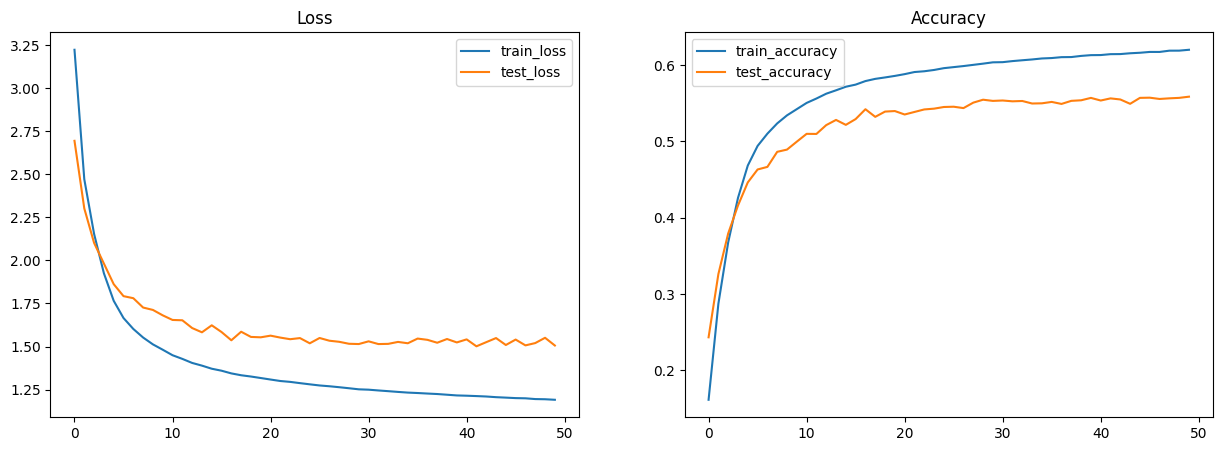

<Figure size 640x480 with 0 Axes>

In [31]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
    ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
    ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

In [32]:

logits = fin_model.apply(fin_params, xb, training=False)
loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=yb).mean()

print(loss)

4.4813905


In [33]:
# def generate_text(idx, max_new_tokens, params):
# # idx is (B, T) array of indices in the current context
#     for i in range(max_new_tokens):
#         # crop idx to the last block_size tokens
#         idx_cond = idx[:, -block_size:]
#         # get the predictions
#         logits = fin_model.apply(params, idx_cond)
#         # focus only on the last time step
#         logits = logits[:, -1, :] # becomes (B, C)

#         if i == 0:
#             rng, rng_subkey = jax.random.split(jax.random.PRNGKey(12))
#         else:
#             rng, rng_subkey = jax.random.split(rng)
            
#         idx_next = jax.random.categorical(rng_subkey, logits, axis=-1, shape=(1, 1)) # (B, 1)

        
#         # append sampled index to the running sequence
#         idx = jnp.concatenate([idx, idx_next], axis=-1) # (B, T+1)

#     return idx    

In [34]:
@partial(jax.jit, static_argnames=("self", "length"))
def generate_text(rng, params, length):
    def _scan_generate(carry, _):
        random_key, context = carry
        logits = fin_model.apply(params, context, training=False)
        rng, rng_subkey = jax.random.split(random_key)
        new_token = jax.random.categorical(
          rng_subkey, logits[:, -1, :], axis=-1, shape=(1, 1)
        )
        context = jnp.concatenate([context[:, 1:], new_token], axis=1)
        return (rng, context), new_token

    _, new_tokens = jax.lax.scan(
    _scan_generate,
    (rng, jnp.zeros((1, block_size), dtype=jnp.int32)),
    (),
    length=length,
    )
    return new_tokens

/opt/conda/lib/python3.10/site-packages/jax/_src/api_util.py:231: SyntaxWarning: Jitted function has invalid argnames {'self'} in static_argnames. Function does not take these args.This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has invalid argnames {invalid_argnames} "


In [35]:
new_tokenz = 1000
key, subkey = jax.random.split(jax.random.PRNGKey(156))
# key, subkey = jax.random.split(key)
# token_gen = generate_text(jnp.zeros((1,block_size)).astype(jnp.int32), new_tokenz, {'params': state.params})
token_gen = generate_text(key, {'params': state.params}, new_tokenz)[:, 0, 0].tolist()
print(token_gen)
print(decode(token_gen))

[24, 17, 27, 26, 32, 17, 31, 10, 0, 27, 6, 1, 50, 43, 58, 1, 51, 43, 1, 57, 54, 43, 39, 49, 6, 1, 47, 44, 1, 63, 53, 59, 5, 50, 50, 1, 40, 43, 1, 42, 56, 43, 39, 42, 8, 0, 0, 31, 21, 15, 21, 26, 21, 33, 31, 10, 0, 26, 53, 58, 1, 21, 1, 56, 43, 41, 43, 47, 60, 43, 42, 1, 47, 58, 6, 1, 54, 43, 56, 57, 53, 52, 8, 0, 0, 25, 27, 26, 32, 13, 19, 33, 17, 10, 0, 31, 61, 43, 50, 50, 6, 1, 58, 46, 39, 58, 1, 57, 43, 43, 57, 6, 1, 44, 56, 53, 51, 1, 46, 43, 39, 60, 43, 52, 1, 61, 46, 47, 54, 54, 43, 42, 1, 63, 53, 59, 1, 51, 59, 57, 58, 1, 49, 52, 53, 61, 0, 27, 44, 1, 51, 63, 1, 49, 52, 43, 43, 57, 6, 1, 47, 52, 42, 59, 41, 58, 47, 53, 52, 1, 54, 47, 41, 58, 1, 46, 39, 42, 1, 43, 56, 56, 39, 63, 43, 42, 1, 46, 53, 59, 57, 43, 50, 44, 1, 46, 39, 60, 43, 1, 47, 52, 0, 40, 43, 45, 47, 52, 52, 1, 53, 44, 1, 58, 46, 47, 57, 1, 44, 53, 59, 52, 42, 39, 58, 47, 53, 52, 8, 0, 0, 34, 27, 24, 33, 25, 26, 21, 13, 10, 0, 32, 39, 49, 43, 1, 58, 46, 63, 1, 42, 56, 53, 53, 54, 57, 1, 39, 52, 42, 1, 42, 53, 61, 

In [36]:
print(decode(token_gen))

LEONTES:
O, let me speak, if you'll be dread.

SICINIUS:
Not I received it, person.

MONTAGUE:
Swell, that sees, from heaven whipped you must know
Of my knees, induction pict had errayed houself have in
beginn of this foundation.

VOLUMNIA:
Take thy droops and down for brief is easter,
But thou canst laugh. What dost thou fort marry
Whom at that two and embold conspirations
because her once that back as you are a horse,
And by noble Ahundren shall take you dreams,
And yield upon it.

PRULINA:
Here comes! here incension where is
Your mercy: the matter of good, if got so.

SICINIUS:
Yes, so man is not proofs, being eat sufferance prevail't:
Was they give got thee hold thee in hell.
Richard blame! Lords, what I for my lawful bawd!
With my husband, my lord. for our lordship are unmaided,
You did make alcour it.

LADY CAPULET:
It is a most hours, to set his bloid, as a late.

LUCIO:
That do you encourage. O, ha, this weep now that do
With two men? methis unworthy Romans is tender;
Which'st 

In [37]:
att_model = NanoLM(
    vocab_size=vocab_size,
    num_layers=4,
    num_heads=8,
    head_size=32,
    dropout_rate=0.2,
    embed_size=256,
    block_size=64,
)

var_params = att_model.init(
    key,
    jnp.ones((batch_size, block_size), dtype=jnp.int32),
    training=False,
)

n_params = sum(p.size for p in jax.tree_util.tree_leaves(var_params))

print(f"Total number of parameters: {n_params:_}")

Total number of parameters: 2_289_089


In [38]:
jax.random.categorical(jax.random.PRNGKey(100), jnp.array([10.0,-10.0,-10.0,10.0,-11.0,-11.0,-11.0,-100.0,-1000]))

Array(3, dtype=int32)

In [39]:
logitss = state.apply_fn({'params': state.params}, (43*jnp.zeros((1,1))).astype(jnp.int32))[:,-1,:]

TypeError: NanoLM.__call__() missing 1 required positional argument: 'training'

In [ ]:
token_gen[:,-32:]

In [ ]:
print("gen text: ",print(decode(token_gen[0].tolist())), "end of text")

In [ ]:
jax.random.randint(jax.random.PRNGKey(52), (1,32), minval, maxval

In [ ]:
import torch
from torch.nn import functional as F
import numpy as np

logitss = state.apply_fn({'params': state.params}, xbb[0].reshape(1,32))[:,-1,:]

probs = F.softmax(torch.from_numpy(np.asarray(logitss)), dim=-1) # (B, C)
# sample from the distribution
idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
idx_next

In [ ]:
1.